In [75]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from  seaborn import heatmap


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#import cdsw
import sys 


"""
Program receives two (2) input arguments
    :param file: filename pattern differentiator. Example: FD001, FD002, FD003, FD004
    :type file : string

    :param Cycle_Alert_Threshold: Threshold for cycles remaining
    :type Cycle_Alert_Threshold: int
"""

#DEFAULT VALUES
file = 'FD001'
Cycle_Alert_Threshold = 40

file_relative_path = "../data/"  ## To be changed to an environment variable

train_filename    = "train_" + file + ".csv"
test_filename     = "test_" + file + ".csv"
test_RUL_filename = "RUL_" + file + ".txt"


"""
STEP 0.0:  Functons from refactoring, will be moved out into a utils.py file out of Jupyter
"""
def columnsToDrop():
    var_thr = VarianceThreshold() #Removing both constant and quasi-constant
    #  keep other columns except ENGINE_NUMBER and Will_Fail (i.e y)
    feature_check_df = train_df.loc[:, ~train_df.columns.isin(['ENGINE_NUMBER', 'willFail' ])]
    var_thr.fit(feature_check_df.values)

    constantColumns = [column for column in feature_check_df.columns 
            if column not in feature_check_df.columns[var_thr.get_support()]]
    
    # Dropping Engine Number and Time in Cycles per the Nasa Turbo fan study recommendations
    dropColumns =   ['ENGINE_NUMBER', 'TIME_IN_CYCLES'] + constantColumns
    return dropColumns

def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))


def processTestData(filename):
  data = pd.read_csv(filename)

  #---------------------------------------------
  # X_test:
  #     Data for the last point before failure of each engine
  #---------------------------------------------
  X_test = pd.DataFrame(data)

  # create temporary dataframe that contains engine_number and maximum number of cycles
  temp = X_test.groupby('ENGINE_NUMBER')['TIME_IN_CYCLES'].max().reset_index()
  temp.columns = ['ENGINE_NUMBER','MAX']

  # append temporary dataframe to end of X_test
  X_test = X_test.merge(temp, on=['ENGINE_NUMBER'], how='left')

  # append 'delete' column which contains the difference between cycles and maximum cycles
  X_test['DELETE'] = X_test['TIME_IN_CYCLES'] - X_test['MAX']

  # removes all rows that difference between cycles is non-zero
  # this gives us the data for the last point for each engine
  X_test = X_test[X_test['DELETE'] == 0]

  # final cleanup to remove unnecessary columns
  colsDrop = columnsToDrop()
  X_test.drop(columns = colsDrop, inplace=True)
  X_test.drop(columns = ["MAX","DELETE"], inplace=True)
  return X_test.values

def plot_graph(var_name , train, ax):
    for itr in train['ENGINE_NUMBER'].unique():
        if (itr % 8 == 0):  # only 8th unit of Engine else the graph becomes too noisy
            ax.plot('RUL', var_name, 
                     data=train[train['ENGINE_NUMBER']==itr])
    ax.set_xlim(250,0) # reversing the axis allows us to see reducing RUL and impact of the variable
    ax.set_xticks(np.arange(0, 275, 25))
    ax.set_ylabel(var_name ,fontsize=12)
    ax.set_xlabel('RUL(Time Cycles)', fontsize=12)


def cross_validate(model, X_values, y_values):
    # Cross Validation to get a more reliable measure of our model
    kfold = KFold( n_splits=10, random_state=7, shuffle=True )
    results = cross_val_score(model, X_values, y_values,scoring='neg_mean_absolute_error',  cv=kfold)
    print("Cross Validation : %0.2f accuracy with a standard deviation of %0.2f" % (np.absolute(results.mean()), results.std())) # Train set needs to be refined further

"""
STEP 1: Starting point : Fetch DATA 
"""

# Step 0.1 : Load our Datasets
train_df = pd.read_csv(file_relative_path + train_filename)

# true_RUL: The 'true' RUL test values are provided, these are used for testing the predictions of our Test Data set 
true_RUL = pd.read_csv(file_relative_path + test_RUL_filename, names=["RUL"])




In [76]:
# DAta Exploration
#train_df.describe()
train_df.columns
index_names = ['ENGINE_NUMBER', 'TIME_IN_CYCLES']
setting_names = [ 'SETTING_1', 'SETTING_2']
sensor_names = [ 'TRA','T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'NF', 'NC', 'EPR',
                 'PS30', 'PHI', 'NRF', 'NRC', 'BPR', 'FARB', 'HTBLEED', 'NF_DMD','PCNFR_DMD'
                 ,'W31', 'W32',
                ]
y_column = ['RUL']
col_names = index_names + setting_names + sensor_names + y_column


In [77]:

train_df[index_names].describe() 
train_df[index_names].groupby('ENGINE_NUMBER').max().describe()

,TIME_IN_CYCLES
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


#### Observations :
When we inspect the descriptive statistics of __ENGINE_NUMBER__ we can see the dataset has a total of 20631 rows, unit numbers start at 1 and end at 100 as expected. What’s interesting, is that the mean and quantiles don’t align neatly with the descriptive statistics of a vector from 1–100, this can be explained due to each unit having different max __TIME_IN_CYCLES__ and thus a different number of rows. <br>
> Note the following :
1. Earliest Engine failure is in 128 Cycles 
2. Engines last between 177 to 229 Cycles 



In [78]:

train_df[setting_names +  sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SETTING_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
SETTING_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
TRA,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
T2,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
T24,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
T30,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
T50,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
P2,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
P15,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
P30,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600


#### Observations
> It can be seen that Columns __TRA__, __T2__, __P2__,  __EPR__, __NF_DMD__, __PCNFR_DMD__ are constants and these features can be eliminated from our featureset, there are some features can be observed with quite  low fluctuations (e.g. P15, FARB)

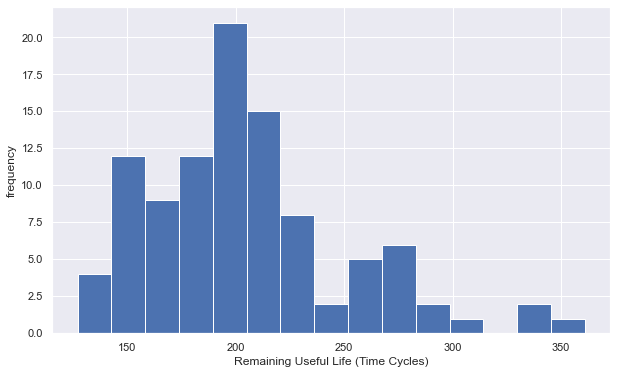

In [79]:
df_max_rul = train_df[['ENGINE_NUMBER', 'RUL']].groupby('ENGINE_NUMBER').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(10,6))
plt.xlabel('Remaining Useful Life (Time Cycles)')
plt.ylabel('frequency')
plt.show()

#### Observations
> Plotting histogram is a good way to see the data distribution and we observe Engine Breakdowns start appearing from 200 time cycles 

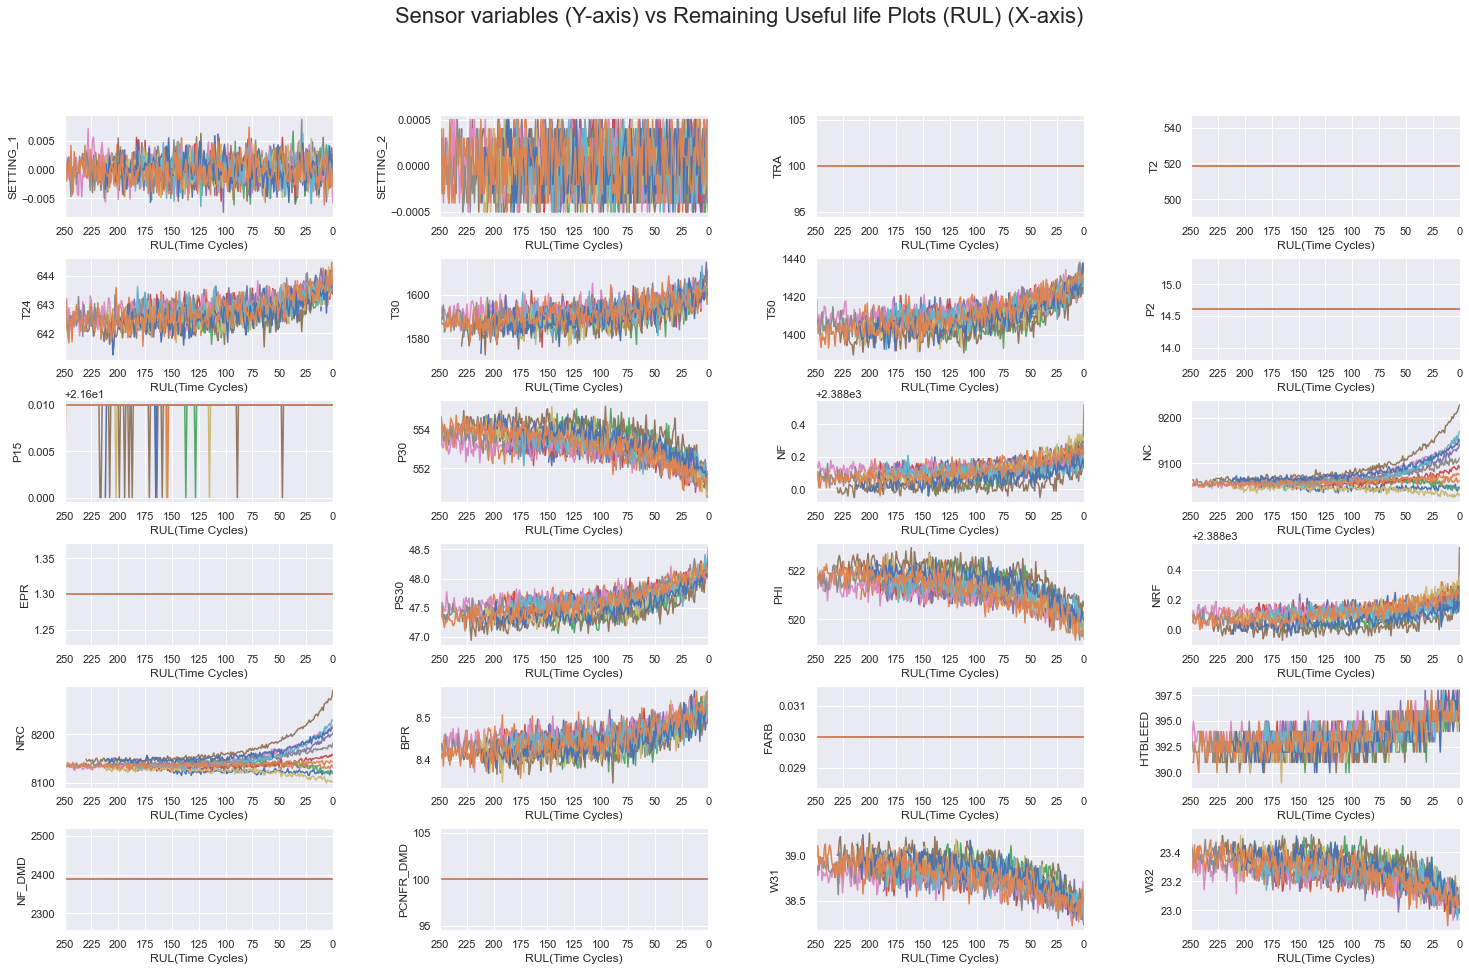

In [80]:
#lets plot a few sensors of Iterest
fig = plt.figure(figsize=(25,15))
fig.suptitle ( "Sensor variables (Y-axis) vs Remaining Useful life Plots (RUL) (X-axis)", fontsize=22)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for idx, var in enumerate(setting_names + sensor_names, 1) :
    ax = fig.add_subplot(6, 4, idx)
    plot_graph(var, train_df, ax)
plt.show()

#### Observations
> We make subplots of variables against Remaining Useful life to see how they influence Remaining Useful life
1. We use a subset of the data (for.example here every 8th Engine data is plotted) to study the impact of the features
2. Remaining useful life is on X axis and is plotted in reverse i.e. to study the sensor measure near the end of day life.  

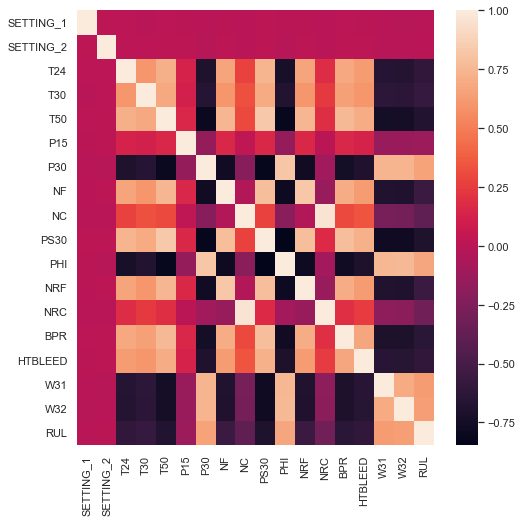

In [81]:
# Another Option is to use a corelation heatmap to study 
fig = plt.figure(figsize=(8,8))
corrMatrix = train_df.drop(columns = columnsToDrop(), axis=1, inplace=False).corr()
heatmap(corrMatrix, annot=False)
plt.show()

#### Observation : 
Multicollinearity reduces the precision of the estimated coefficients, which weakens the statistical power of your regression model. Here some variables exhibit  multicolinearity e.g. NF and T50 , T50 and T24. So in another experiment we could choose to remove features with multi-collinearity and evaluate the model

In [82]:


## Time to get to modelling. 
"""
STEP 1: TRAINING DATA - Filter unnecessary data
"""


dropColumns = columnsToDrop()
print('Following Columns are dropped from Train dataset {0}'.format(dropColumns))

X_train = train_df.drop(columns = dropColumns, axis=1, inplace=False)
X_train.drop(columns = ["RUL"], axis=1, inplace=True)                # used for y-value
X_train = X_train.values
y_train = train_df.RUL.values
X_test =  processTestData(file_relative_path + test_filename)
y_test = true_RUL.values

### Scaling the Input features to minimize any outlier impacts. 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



"""
STEP 2A: Creating a baseline Regression Model  
"""


print("EVALUATING RUL for Base Model : ")
lmodel = LinearRegression()
lmodel.fit(X_train, y_train)

# Cross Validation to get a more reliable measure of our model
cross_validate(lmodel, X_train, y_train)

# prediction
y_hat_test_lr = lmodel.predict(X_test)
# evaluate Prediction performance
evaluate(y_test, y_hat_test_lr, 'test')

"""
STEP 2B: Decision Tree Regressor
"""

print("EVALUATING RUL for Decision Tree Model : ")
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)


# Cross Validation to get a more reliable measure of our model
cross_validate(tree_reg, X_train, y_train)

#prediction
y_hat_test_dtree = tree_reg.predict(X_test)

#evaluate model performance
evaluate(y_test, y_hat_test_dtree, 'test')

"""
STEP 2C: Random Forest Regressor 
"""

print("EVALUATING RUL for Random Forest Regressor : ")

fr_reg = RandomForestRegressor()
fr_reg.fit(X_train, y_train)

# Cross Validation to get a more reliable measure of our model
cross_validate(fr_reg, X_train, y_train)

# predict 
y_hat_test_fr = fr_reg.predict(X_test)

#evaluate model performance
evaluate(y_test, y_hat_test_fr, 'test')



"""
STEP 2D: Trying out XGB Regressor with some known hyperparameters from internal / external papers/ articles etc.  
"""
print("EVALUATING RUL for XGBR Model : ")
xgbr_model = xgb.XGBRegressor( n_estimators=85, learning_rate=0.018, gamma=0, subsample=0.5,
                           colsample_bytree=0.5, max_depth=3)
xgbr_model.fit(X_train,y_train)



# rul_df = train_df.groupby('ENGINE_NUMBER')['RUL'].max() \
#                 .reset_index() \
#                 .rename(columns={'max':'RUL'})

# Cross Validation to get a more reliable measure of our model
cross_validate(xgbr_model, X_train, y_train)

# predict and evaluate
y_hat_test_xgbr = xgbr_model.predict(X_test)

evaluate(y_test, y_hat_test_xgbr, 'test')



Following Columns are dropped from Train dataset ['ENGINE_NUMBER', 'TIME_IN_CYCLES', 'TRA', 'T2', 'P2', 'EPR', 'FARB', 'NF_DMD', 'PCNFR_DMD']
EVALUATING RUL for Base Model : 
Cross Validation : 34.14 accuracy with a standard deviation of 0.54
test set RMSE:32.04109478174249, R2:0.4054954961204911
EVALUATING RUL for Decision Tree Model : 
Cross Validation : 41.38 accuracy with a standard deviation of 0.69
test set RMSE:52.24633958470201, R2:-0.5807099737003887
EVALUATING RUL for Random Forest Regressor : 
Cross Validation : 29.58 accuracy with a standard deviation of 0.53
test set RMSE:33.61330327415025, R2:0.34572120732219735
EVALUATING RUL for XGBR Model : 
Cross Validation : 34.70 accuracy with a standard deviation of 0.81
test set RMSE:19.03098676294852, R2:0.7902687862641615


In [83]:
# training a Regression MLP using Sequential API 
from sklearn.model_selection import train_test_split
from tensorflow  import keras 

X_train_sub1, X_valid, y_train_sub1, y_valid = train_test_split(X_train, y_train)
scaler = StandardScaler()
X_train_sub1_scaled = scaler.fit_transform(X_train_sub1)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

model = keras.models.Sequential([
 keras.layers.Dense(100, activation="relu", input_shape=X_train_sub1_scaled.shape[1:]),
 keras.layers.Dense(1)
 ])
model.compile(loss="mse", optimizer="adam",   metrics=[keras.metrics.RootMeanSquaredError()])
model.fit(X_train_sub1_scaled, y_train_sub1, epochs=20,
                    validation_data=(X_valid, y_valid))
y_hat_test_MLP = model.predict(X_test_scaled)
evaluate(y_test, y_hat_test_MLP)

Epoch 1/20
484/484 [==============================] - 0s 675us/step - loss: 9453.4814 - root_mean_squared_error: 97.2290 - val_loss: 4344.6919 - val_root_mean_squared_error: 65.9143
Epoch 2/20
484/484 [==============================] - 0s 547us/step - loss: 3335.3779 - root_mean_squared_error: 57.7527 - val_loss: 2597.9978 - val_root_mean_squared_error: 50.9706
Epoch 3/20
484/484 [==============================] - 0s 538us/step - loss: 2221.3206 - root_mean_squared_error: 47.1309 - val_loss: 1952.1602 - val_root_mean_squared_error: 44.1833
Epoch 4/20
484/484 [==============================] - 0s 554us/step - loss: 1835.5310 - root_mean_squared_error: 42.8431 - val_loss: 1786.5303 - val_root_mean_squared_error: 42.2674
Epoch 5/20
484/484 [==============================] - 0s 542us/step - loss: 1747.9946 - root_mean_squared_error: 41.8090 - val_loss: 1756.8550 - val_root_mean_squared_error: 41.9149
Epoch 6/20
484/484 [==============================] - 0s 546us/step - loss: 1726.7087 - ro

#### Observation: 
1. Here we are making a comparison across Regressors. Before evaluating on Test Data, we evaluate model on training data by using Nfold Cross validation
2. Here further work can be done into parameter tuning and feature engineering. For example one observation in most models is test sets are outperforming the training sets, while it is normally the other way around. Study of papers on this dataset suggests that assumption of linear relationship of RUL degradation with time ( last column in Test data) is not valid. __This Needs more investigation for model performance improvement__

In [84]:

"""
STEP 4: Training an  XGBoost Classifiers for Classifying Fail/ Not Fail based on predefined Threshold
"""
# Training a classifier ( Directly training XGBoost here but the same approach as for the Regressor would be adopted here.)
train_df['willFail'] = np.where(train_df['RUL'] <= Cycle_Alert_Threshold, 1, 0 )
train_y = train_df['willFail']
xgbCl_model = xgb.XGBRFClassifier()
xgbCl_model.fit(X_train, train_y)
true_RUL_class = pd.DataFrame()
true_RUL_class['willFail'] = np.where(true_RUL['RUL'] <= Cycle_Alert_Threshold, 1, 0)
true_RUL_class = true_RUL_class.values
pred_fail = xgbCl_model.predict(X_test)
accuracy = "{:.2f}%".format(accuracy_score(true_RUL_class, pred_fail) * 100)

#+-------------+-------------+
y_real = np.transpose(np.squeeze(true_RUL_class))
y_pred = np.array(pred_fail)
AUC = "{:.2f}".format(roc_auc_score(y_real, y_pred))

tn,fp,fn,tp = confusion_matrix(y_real,y_pred).ravel() 

print('tp={0} tn={1} \nfn={2} fp={3}'.format( tp, tn, fn, fp))
print(f"Accuracy: {accuracy}")
print(f"AUC: {AUC}")


tp=22 tn=71 
fn=6 fp=1
Accuracy: 93.00%
AUC: 0.89


In [86]:
# Save Regressor model to disk 
import pickle
filename = "pred_RUL.pkl"
model_path = "../model/"

with open(model_path + filename, 'wb') as files:
    pickle.dump(xgbr_model, files)

In [87]:
## Load Model from Disk and evaluate a sample record to check if model gets loaded.

import imp 
from utils import prepare_test_data

# open saved model ... This needs to be part of main function called model_serv.py, so model needs to be loaded just once
filename = "pred_RUL.pkl"
with open(model_path + filename , 'rb') as f:
    model = pickle.load(f)

## Check that the model prediction works ok here
try :
    sample_record = [1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.30,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.00,38.86,23.3735]
    x_check = prepare_test_data(sample_record)
    y_check = model.predict(x_check)
    if round(y_check[0]) > 130  | round(y_check[0]) < 125 :
        raise ValueError 
    print('y_check :{0}'.format(y_check) )
except ValueError:
    print('Invalid Value from Predict Model, expecting result 130, getting {0}'.format(round(y_check[0])))
    raise    


y_check :[34.31955]
